In [ ]:
!pip install opencv-contrib-python

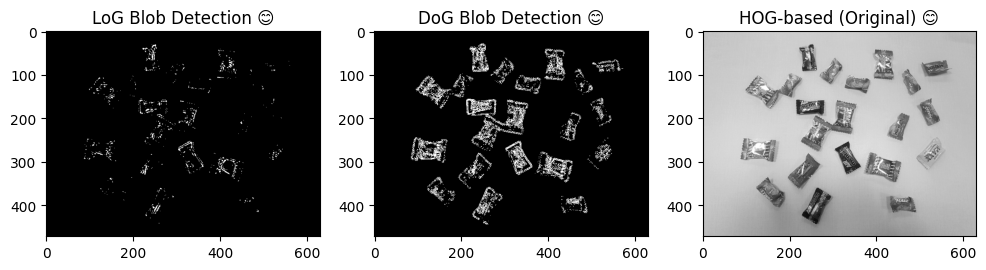

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a grayscale image (e.g. microscope image of platelets)
image = cv2.imread("/content/Candy.png", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image not found! Please check your path.")

# ----- LoG (Laplacian of Gaussian) Blob Detection -----
def blob_detection_log(image):
    # First, smooth the image using Gaussian Blur
    blurred = cv2.GaussianBlur(image, (9, 9), 0)
    # Compute Laplacian to highlight regions of rapid intensity change
    log = cv2.Laplacian(blurred, cv2.CV_64F)
    # Threshold the absolute response to detect blobs
    _, log_thresh = cv2.threshold(np.abs(log).astype(np.uint8), 10, 255, cv2.THRESH_BINARY)
    return log_thresh

# ----- DoG (Difference of Gaussian) Blob Detection -----
def blob_detection_dog(image):
    blur1 = cv2.GaussianBlur(image, (5,5), 1)
    blur2 = cv2.GaussianBlur(image, (5,5), 2)
    dog = cv2.absdiff(blur1, blur2)
    _, dog_thresh = cv2.threshold(dog, 5, 255, cv2.THRESH_BINARY)
    return dog_thresh

# ----- HOG-based Approach for Blob Detection -----
def blob_detection_hog(image):
    # Initialize HOGDescriptor
    hog = cv2.HOGDescriptor()
    # Compute HOG features (for real applications, you would visualize or further process these features)
    hog_features = hog.compute(image)
    # For demonstration, we return the original image (as visualizing HOG requires additional steps)
    return image

# Apply detection techniques
log_blobs = blob_detection_log(image)
dog_blobs = blob_detection_dog(image)
hog_blobs = blob_detection_hog(image)

# Display results
plt.figure(figsize=(12,4))
plt.subplot(131), plt.imshow(log_blobs, cmap='gray'), plt.title("LoG Blob Detection 😊")
plt.subplot(132), plt.imshow(dog_blobs, cmap='gray'), plt.title("DoG Blob Detection 😊")
plt.subplot(133), plt.imshow(hog_blobs, cmap='gray'), plt.title("HOG-based (Original) 😊")
plt.show()


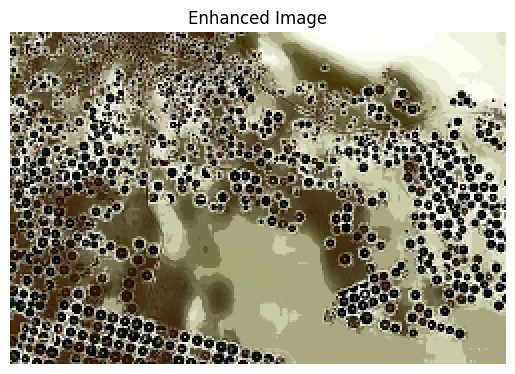

In [ ]:
def enhance_image(image):
    # 1. Adjust brightness and contrast
    alpha = 1.2  # Contrast control (1.0-3.0)
    beta = 20    # Brightness control (0-100)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # 2. Sharpen image using a convolution kernel
    kernel_sharpening = np.array([[-1,-1,-1],
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
    sharpened = cv2.filter2D(adjusted, -1, kernel_sharpening)

    # 3. Remove noise using Non-Local Means Denoising
    denoised = cv2.fastNlMeansDenoisingColored(sharpened, None, 10, 10, 7, 21)

    # 4. Enhance color via histogram equalization (on the Y channel in YCrCb space)
    img_yuv = cv2.cvtColor(denoised, cv2.COLOR_BGR2YCrCb)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    color_corrected = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)

    # 5. Resize image (scaling down by half for demonstration)
    resized = cv2.resize(color_corrected, (image.shape[1]//2, image.shape[0]//2))

    return resized

# Load a sample color image
image_color = cv2.imread("/content/Sate.png")
if image_color is None:
    raise FileNotFoundError("Sample image not found! Please check your path.")

enhanced_img = enhance_image(image_color)

# Display the enhanced image (convert BGR to RGB for proper display with matplotlib)
plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
plt.title("Enhanced Image")
plt.axis("off")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001
num_classes = 100

# Data augmentation and normalization for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

# Load CIFAR-100 datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to load and modify the pre-trained ResNet model
def get_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    else:
        raise ValueError("Model not supported!")
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Training function
def train_model(model, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

# Initialize models
models_to_train = {
    'ResNet18': get_model('resnet18'),
    'ResNet34': get_model('resnet34')
}

results = {}
for model_name, model in models_to_train.items():
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    print(f"Training {model_name} ")
    for epoch in range(num_epochs):
        train_loss = train_model(model, optimizer, criterion)
        test_loss, accuracy = evaluate_model(model, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    results[model_name] = accuracy

print("Final Results:", results)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weig

Training ResNet18 
Epoch [1/10] ResNet18 - Train Loss: 3.0260, Test Loss: 2.5205, Accuracy: 34.62%
Epoch [2/10] ResNet18 - Train Loss: 2.2900, Test Loss: 2.1533, Accuracy: 42.38%
Epoch [3/10] ResNet18 - Train Loss: 2.0445, Test Loss: 1.9572, Accuracy: 47.36%
Epoch [4/10] ResNet18 - Train Loss: 1.8813, Test Loss: 1.8936, Accuracy: 48.76%
Epoch [5/10] ResNet18 - Train Loss: 1.7747, Test Loss: 1.9775, Accuracy: 48.08%
Epoch [6/10] ResNet18 - Train Loss: 1.6693, Test Loss: 1.7693, Accuracy: 51.98%
Epoch [7/10] ResNet18 - Train Loss: 1.5788, Test Loss: 1.7949, Accuracy: 51.64%
Epoch [8/10] ResNet18 - Train Loss: 1.4948, Test Loss: 1.6845, Accuracy: 54.73%
Epoch [9/10] ResNet18 - Train Loss: 1.4251, Test Loss: 1.7041, Accuracy: 53.59%
Epoch [10/10] ResNet18 - Train Loss: 1.3679, Test Loss: 1.6947, Accuracy: 54.61%
Training ResNet34 
Epoch [1/10] ResNet34 - Train Loss: 3.1155, Test Loss: 2.6442, Accuracy: 35.37%
Epoch [2/10] ResNet34 - Train Loss: 2.4518, Test Loss: 2.8334, Accuracy: 31.16%
E

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Set device and random seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# MNIST dataset transformation and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define a simple CNN to extract embeddings from images
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, 5),  # (28-5+1)=24
            nn.ReLU(),
            nn.MaxPool2d(2),      # 24/2=12
            nn.Conv2d(32, 64, 5), # (12-5+1)=8
            nn.ReLU(),
            nn.MaxPool2d(2)       # 8/2=4
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 256),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Compute class prototypes (mean embedding per class)
def compute_prototypes(embeddings, targets, num_classes):
    prototypes = []
    for cls in range(num_classes):
        cls_indices = (targets == cls).nonzero().squeeze()
        cls_embeddings = embeddings[cls_indices]
        prototype = cls_embeddings.mean(0)
        prototypes.append(prototype)
    return torch.stack(prototypes)



# Episodic training for few-shot learning using a prototypical network
def episodic_training(embedding_net, optimizer, num_episodes=100, num_classes=5, k_shot=5, q_query=10):
    embedding_net.train()
    loss_fn = nn.CrossEntropyLoss()
    for episode in range(num_episodes):
        # Randomly select 'num_classes' classes for this episode
        classes = np.random.choice(np.unique(mnist_train.targets.numpy()), num_classes, replace=False)
        support_images, support_labels = [], []
        query_images, query_labels = [], []

        # For each class, select k_shot support examples and q_query query examples
        for idx, cls in enumerate(classes):
            cls_indices = np.where(mnist_train.targets.numpy() == cls)[0]
            selected = np.random.choice(cls_indices, k_shot + q_query, replace=False)
            support_idx = selected[:k_shot]
            query_idx = selected[k_shot:]
            for i in support_idx:
                img, _ = mnist_train[i]
                support_images.append(img)
                support_labels.append(idx)
            for i in query_idx:
                img, _ = mnist_train[i]
                query_images.append(img)
                query_labels.append(idx)

        support_images = torch.stack(support_images).to(device)
        support_labels = torch.tensor(support_labels).to(device)
        query_images = torch.stack(query_images).to(device)
        query_labels = torch.tensor(query_labels).to(device)

        optimizer.zero_grad()
        support_embeddings = embedding_net(support_images)
        query_embeddings = embedding_net(query_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, num_classes)

        # Calculate Euclidean distances between query embeddings and prototypes
        dists = torch.cdist(query_embeddings, prototypes)
        logits = -dists  # lower distance means higher similarity
        loss = loss_fn(logits, query_labels)
        loss.backward()
        optimizer.step()

        if (episode+1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f} ")

# Initialize model and optimizer
embedding_net = EmbeddingNet().to(device)
optimizer = optim.Adam(embedding_net.parameters(), lr=0.001)

print("Starting Episodic Training for Prototypical Network")
episodic_training(embedding_net, optimizer)


100%|██████████| 9.91M/9.91M [00:00<00:00, 120MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 27.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 66.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.24MB/s]


Starting Episodic Training for Prototypical Network
Episode 10/100, Loss: 0.3389 
Episode 20/100, Loss: 0.3230 
Episode 30/100, Loss: 0.2717 
Episode 40/100, Loss: 0.4521 
Episode 50/100, Loss: 0.1182 
Episode 60/100, Loss: 0.2752 
Episode 70/100, Loss: 0.2893 
Episode 80/100, Loss: 0.0601 
Episode 90/100, Loss: 0.0737 
Episode 100/100, Loss: 0.0654 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style for better visuals
sns.set(style="whitegrid")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001
num_classes = 100

# Data augmentation and normalization for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

# Load CIFAR-100 datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to load and modify the pre-trained ResNet model
def get_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    else:
        raise ValueError("Model not supported!")
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Training function that saves metrics
def train_model(model, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

# Evaluation function that saves metrics
def evaluate_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

# Initialize models and prepare to store metrics
models_to_train = {
    'ResNet18': get_model('resnet18'),
    'ResNet34': get_model('resnet34')
}

results = {}
history = {}  # To store training and testing metrics for each model

for model_name, model in models_to_train.items():
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    history[model_name] = {'train_loss': [], 'test_loss': [], 'accuracy': []}
    print(f"Training {model_name} ")
    for epoch in range(num_epochs):
        train_loss = train_model(model, optimizer, criterion)
        test_loss, accuracy = evaluate_model(model, criterion)
        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['test_loss'].append(test_loss)
        history[model_name]['accuracy'].append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}% 😊")
    results[model_name] = accuracy

# Visualization: Plotting the training curves and accuracy for each model
epochs = range(1, num_epochs+1)
plt.figure(figsize=(16, 5))

# Plot training loss
plt.subplot(1, 3, 1)
for model_name in history:
    plt.plot(epochs, history[model_name]['train_loss'], marker='o', label=model_name)
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot test loss
plt.subplot(1, 3, 2)
for model_name in history:
    plt.plot(epochs, history[model_name]['test_loss'], marker='o', label=model_name)
plt.title('Testing Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 3, 3)
for model_name in history:
    plt.plot(epochs, history[model_name]['accuracy'], marker='o', label=model_name)
plt.title('Testing Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optionally, print final results in a tabular format
import pandas as pd
df_results = pd.DataFrame({
    'Model': list(results.keys()),
    'Final Accuracy (%)': list(results.values())
})
print("\nFinal Evaluation Metrics:")
print(df_results)


100%|██████████| 169M/169M [00:01<00:00, 103MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weigh

Training ResNet18 
